In [ ]:
import requests
import pandas as pd
import json
from datetime import datetime
from matplotlib import pyplot as plt
from requests import post
import seaborn as sns

In [ ]:
client_id = 'aemva6t7nm16n3594eluwmzsmabjtu'
client_secret = 'pfxcphs4jsgw5dnc6oykq83lb795p8'

auth_url = 'https://id.twitch.tv/oauth2/token'
auth_params = {
    'client_id': client_id,
    'client_secret': client_secret,
    'grant_type': 'client_credentials'
}

auth_response = requests.post(auth_url, data=auth_params)

if auth_response.status_code == 200:
    print("Autenticação bem-sucedida!")
    print("Resposta:")
    print(auth_response.json())
else:
    print(f"Erro: {auth_response.status_code}, {auth_response.reason}")

access_token = auth_response.json()['access_token']

headers = {
    'Client-ID': client_id,
    'Authorization': f'Bearer {access_token}'
}

Autenticação bem-sucedida!
Resposta:
{'access_token': 'jepb59hgju39z8avimbb5f4avlnl7n', 'expires_in': 5551903, 'token_type': 'bearer'}


In [ ]:
def search_game_id(game_name):
    url = 'https://api.igdb.com/v4/games'
    query = f'search "{game_name}"; fields age_ratings,aggregated_rating,aggregated_rating_count,artworks,category,checksum,cover,created_at,first_release_date,game_engines,game_localizations,game_modes,genres,hypes,involved_companies,keywords,language_supports,multiplayer_modes,name,platforms,player_perspectives,rating,rating_count,release_dates,screenshots,slug,status,storyline,summary,tags,themes,total_rating,total_rating_count,updated_at,url,videos,websites;'
    response = requests.post(url, headers=headers, data=query)

    if response.status_code == 200:
        print(f"Dados do jogo {game_name} obtidos com sucesso!")
        return response.json()
    else:
        print(f"Erro ao obter dados do jogo {game_name}: {response.status_code}, {response.reason}")
        return []

games = [
    "Baldur Gate 3",
    "Elden Ring"
    "It Takes Two",
    "The Last of Us Part II",
    "Sekiro: Shadows Die Twice",
    "God of War",
    "The Legend of Zelda: Breath of the Wild",
    "Overwatch",
    "The Witcher 3: Wild Hunt",
    "Dragon Age: Inquisition"
]

result = []

for game in games:
    game_data = search_game_id(game)
    if game_data:
        result.extend(game_data)

df = pd.DataFrame(result)
df= df.dropna(subset=['aggregated_rating'])
#display(df)

Dados do jogo Baldur Gate 3 obtidos com sucesso!
Dados do jogo Elden RingIt Takes Two obtidos com sucesso!
Dados do jogo The Last of Us Part II obtidos com sucesso!
Dados do jogo Sekiro: Shadows Die Twice obtidos com sucesso!
Dados do jogo God of War obtidos com sucesso!
Dados do jogo The Legend of Zelda: Breath of the Wild obtidos com sucesso!
Dados do jogo Overwatch obtidos com sucesso!
Dados do jogo The Witcher 3: Wild Hunt obtidos com sucesso!
Dados do jogo Dragon Age: Inquisition obtidos com sucesso!


In [ ]:
len(df)

25

In [ ]:
df.columns

Index(['id', 'age_ratings', 'aggregated_rating', 'aggregated_rating_count',
       'artworks', 'category', 'cover', 'created_at', 'first_release_date',
       'game_engines', 'game_modes', 'genres', 'hypes', 'involved_companies',
       'keywords', 'multiplayer_modes', 'name', 'platforms',
       'player_perspectives', 'rating', 'rating_count', 'release_dates',
       'screenshots', 'slug', 'storyline', 'summary', 'tags', 'themes',
       'total_rating', 'total_rating_count', 'updated_at', 'url', 'videos',
       'websites', 'checksum', 'language_supports', 'game_localizations',
       'status'],
      dtype='object')

In [ ]:
def get_names_from_ids(endpoint, ids):
    if not ids:
        return {}

    url = f'https://api.igdb.com/v4/{endpoint}'
    ids_str = ','.join(map(str, ids))
    query = f'fields id, name; where id = ({ids_str});'
    response = requests.post(url, headers=headers, data=query)

    if response.status_code == 200:
        return {item['id']: item['name'] for item in response.json()}
    else:
        print(f"Erro ao obter nomes de {endpoint}: {response.status_code}, {response.reason}")
        return {}

def get_release_dates(ids):
    if not ids:
        return {}

    url = 'https://api.igdb.com/v4/release_dates'
    ids_str = ','.join(map(str, ids))
    query = f'fields id, human; where id = ({ids_str});'
    response = requests.post(url, headers=headers, data=query)

    if response.status_code == 200:
        return {item['id']: item['human'] for item in response.json()}
    else:
        print(f"Erro ao obter datas de lançamento: {response.status_code}, {response.reason}")
        return {}

# Obter todos os IDs de gêneros, plataformas, datas de lançamento e modos de jogo
all_genre_ids = set()
all_platform_ids = set()
all_release_date_ids = set()
all_game_mode_ids = set()

for game in result:
    if 'genres' in game:
        all_genre_ids.update(game['genres'])
    if 'platforms' in game:
        all_platform_ids.update(game['platforms'])
    if 'release_dates' in game:
        all_release_date_ids.update(game['release_dates'])
    if 'game_modes' in game:
        all_game_mode_ids.update(game['game_modes'])

# Buscar os nomes correspondentes
genre_names = get_names_from_ids('genres', all_genre_ids)
platform_names = get_names_from_ids('platforms', all_platform_ids)
release_date_names = get_release_dates(all_release_date_ids)
game_mode_names = get_names_from_ids('game_modes', all_game_mode_ids)

# Verificar se os nomes de lançamento e modos de jogo foram obtidos corretamente
print("Nomes de datas de lançamento obtidos:", release_date_names)
print("Nomes de modos de jogo obtidos:", game_mode_names)

# Mapear os nomes para os jogos
def map_names(ids, name_dict):
    return [name_dict.get(id, 'Unknown') for id in ids]

df['genre_names'] = df['genres'].apply(lambda x: map_names(x, genre_names) if isinstance(x, list) else [])
df['platform_names'] = df['platforms'].apply(lambda x: map_names(x, platform_names) if isinstance(x, list) else [])
df['formatted_release_dates'] = df['release_dates'].apply(lambda x: map_names(x, release_date_names) if isinstance(x, list) else [])
df['game_mode_names'] = df['game_modes'].apply(lambda x: map_names(x, game_mode_names) if isinstance(x, list) else [])

# Exibir o DataFrame resultante
display(df[['name', 'genre_names', 'platform_names', 'game_mode_names']])

Nomes de datas de lançamento obtidos: {19623: 'Nov 18, 2014', 19624: 'Nov 18, 2014', 19625: 'Nov 18, 2014', 19626: 'Nov 18, 2014', 19628: 'Nov 21, 2014', 19629: 'Nov 21, 2014', 19630: 'Nov 21, 2014', 19631: 'Nov 21, 2014', 23646: 'Nov 18, 2014', 23647: 'Nov 18, 2014'}
Nomes de modos de jogo obtidos: {1: 'Single player', 2: 'Multiplayer', 3: 'Co-operative', 4: 'Split screen'}


,name,genre_names,platform_names,game_mode_names
0,Baldur's Gate 3,"[Role-playing (RPG), Strategy, Turn-based stra...","[PC (Microsoft Windows), Unknown, PlayStation ...","[Single player, Multiplayer, Co-operative, Spl..."
4,The Last of Us Part II,"[Shooter, Adventure]",[PlayStation 4],[Single player]
5,The Last of Us Part II: Remastered,"[Shooter, Adventure]",[PlayStation 5],[Single player]
11,Sekiro: Shadows Die Twice,"[Unknown, Adventure]","[PC (Microsoft Windows), PlayStation 4, Unknow...",[Single player]
14,God of War,"[Role-playing (RPG), Unknown, Adventure]","[PC (Microsoft Windows), PlayStation 4]",[Single player]
15,God of War II,"[Platform, Unknown, Adventure]",[PlayStation 2],[Single player]
17,God of War: Ascension,"[Unknown, Adventure]",[PlayStation 3],"[Single player, Multiplayer]"
18,God of War Ragnarök,"[Role-playing (RPG), Unknown, Adventure]","[PC (Microsoft Windows), PlayStation 4, PlaySt...",[Single player]
19,God of War Saga,"[Unknown, Adventure]",[PlayStation 3],[Single player]
20,God of War: Origins Collection,"[Unknown, Adventure]",[PlayStation 3],[Single player]


In [ ]:
df_analise = df[['name', 'aggregated_rating', 'genre_names', 'platform_names', 'game_mode_names']]

df_analise = df_analise.applymap(lambda x: [item for item in x if item != 'Unknown'] if isinstance(x, list) else x)

#df_analise

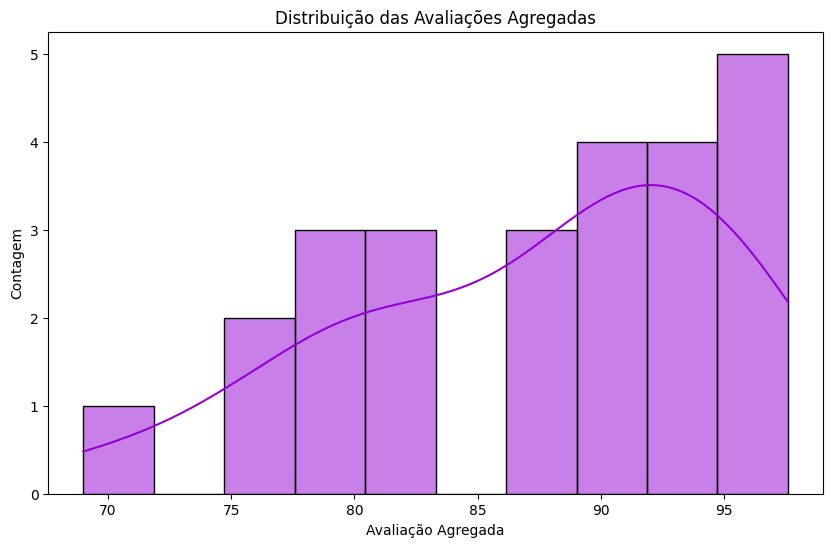

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_analise['aggregated_rating'].explode().dropna(), bins=10, kde=True, color='darkviolet')
plt.title('Distribuição das Avaliações Agregadas')
plt.xlabel('Avaliação Agregada')
plt.ylabel('Contagem')
plt.show()

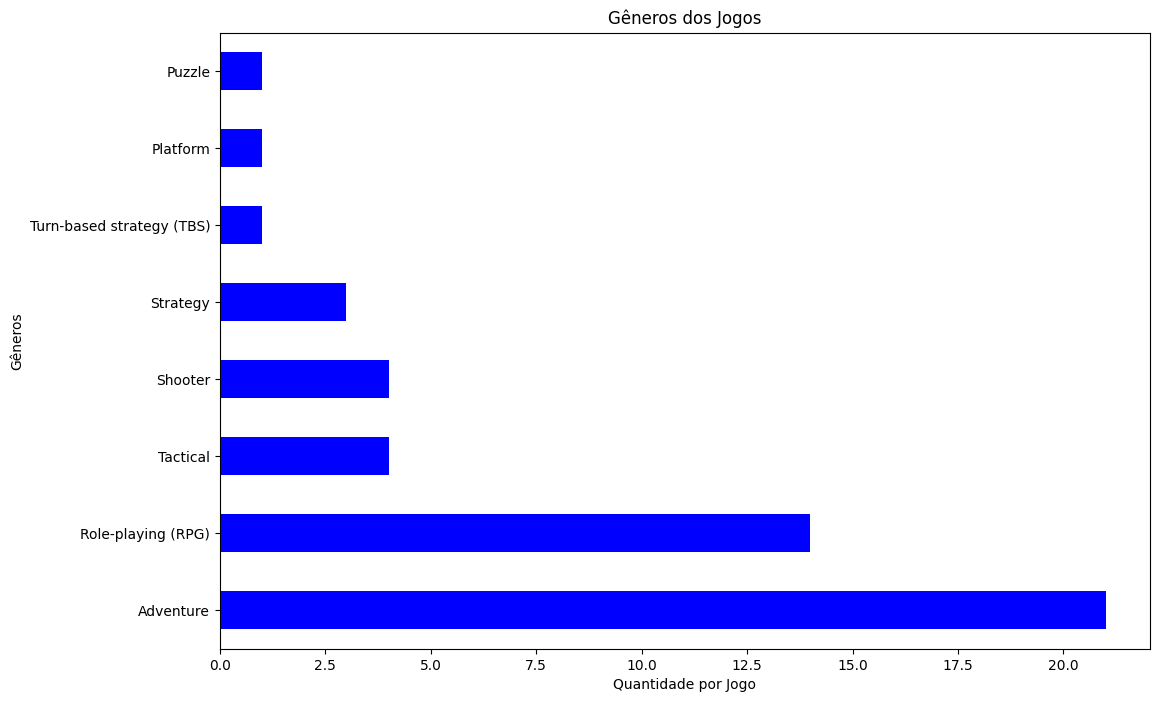

In [ ]:
# Explodir a lista de gêneros para ter uma linha por gênero por jogo
df_genres = df_analise.explode('genre_names')

# Contar o número de generos por jogo
genres_by_game = df_genres['genre_names'].value_counts()

plt.figure(figsize=(12, 8))
genres_by_game.plot(kind='barh', color = 'blue')
plt.title('Gêneros dos Jogos')
plt.xlabel('Quantidade por Jogo')
plt.ylabel('Gêneros')
plt.show()

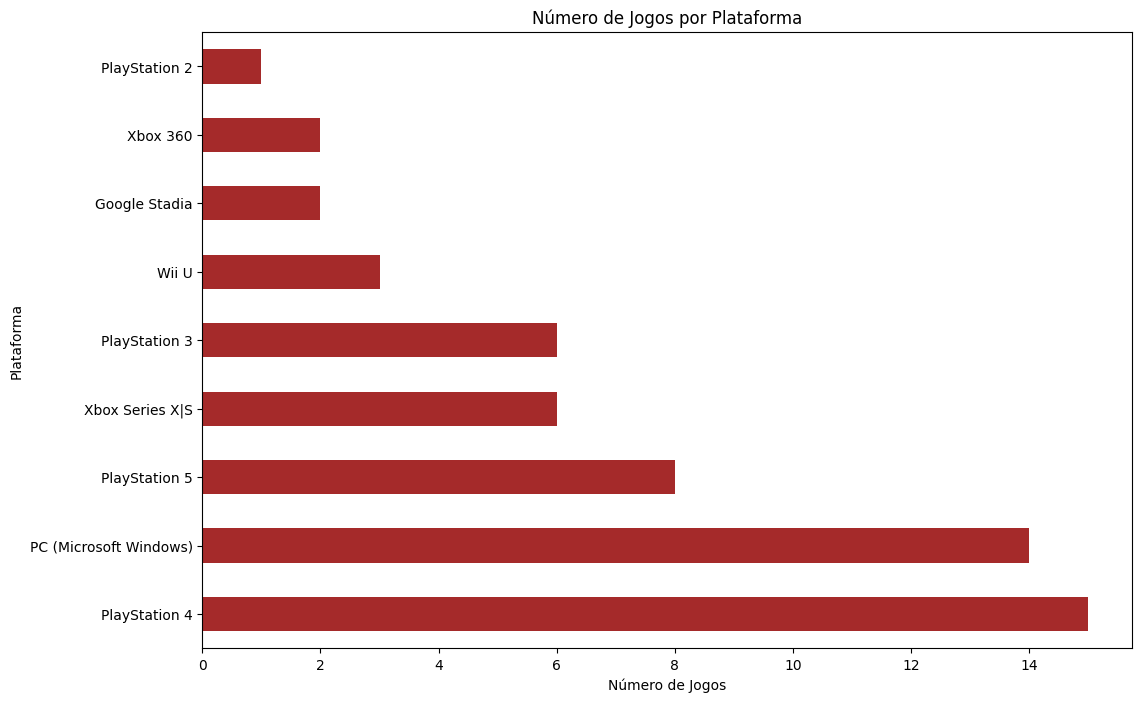

In [ ]:
# Explodir a lista de plataformas para ter uma linha por plataforma por jogo
df_platforms = df_analise.explode('platform_names')

# Contar o número de jogos por plataforma
games_by_platform = df_platforms['platform_names'].value_counts()

plt.figure(figsize=(12, 8))
games_by_platform.plot(kind='barh', color = 'brown')
plt.title('Número de Jogos por Plataforma')
plt.xlabel('Número de Jogos')
plt.ylabel('Plataforma')
plt.show()

Nome dos modos obtidos com sucesso!


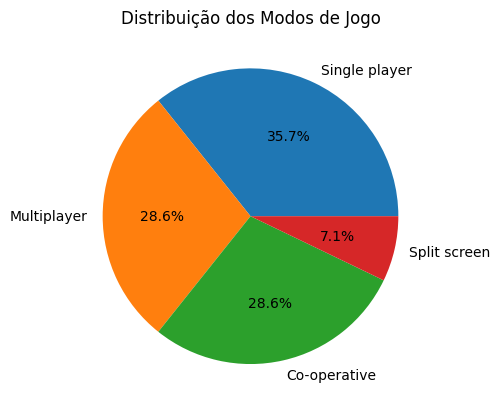

In [ ]:
# Game Modes
fields = 'fields id, name;'

def get_game_modes_data():
    url = 'https://api.igdb.com/v4/game_modes'
    response = requests.post(url, headers=headers, data=fields)

    if response.status_code == 200:
        print("Nome dos modos obtidos com sucesso!")
        return response.json()
    else:
        print(f"Erro ao obter nomes dos modos: {response.status_code}, {response.reason}")
        return []

game_modes_data = get_game_modes_data()

game_modes_dict = {mode['id']: mode['name'] for mode in game_modes_data}

df_analise = pd.DataFrame({
    'game_modes': [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 1, 1, 2, 3, 1, 2, 3]
    # Aqui coloquei a repetição de quantas vezes cada modo aparece (para que o grafico funcionasse corretamente) porem acredito que deva ter outra forma de automatizar
})

df_analise['game_modes'] = df_analise['game_modes'].map(game_modes_dict)

#print(df_analise)

# Plot Game Modes
df_analise['game_modes'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Distribuição dos Modos de Jogo')
plt.ylabel('')
plt.show()

In [ ]:
df_analise.to_csv('dados_jogos_filtrados.csv', index=False)

# df_analise so tem 5 colunas 'name', 'aggregated_rating', 'genre_names', 'platform_names', 'game_mode_names'

In [ ]:
# Empresas:

In [ ]:
def search_changed_company_id(name):
    url = 'https://api.igdb.com/v4/companies'
    data = f'search "{name}"; fields *;'
    response = requests.post(url, headers=headers, data=data)

    if response.status_code == 200:
        print(f"Dados da Empresa {name} obtidos com sucesso!")
        return response.json()
    else:
        print(f"Erro ao obter dados da Empresa {name}: {response.status_code}, {response.reason}")
        return []

def get_companies_data(name):
    company_data = search_changed_company_id(name)
    if company_data:
        df_company = pd.json_normalize(company_data)
        return df_company
    else:
        return None

companies = [
    "Larian Studios",
    "FromSoftware",
    "Hazelight Studios",
    "Electronic Arts",
    "Naughty Dog",
    "Sony Interactive Entertainment",
    "Activision",
    "Santa Monica Studio",
    "Nintendo",
    "Blizzard Entertainment",
    "CD Projekt",
    "BioWare"
]

result = []

for name in companies:
    company_data = get_companies_data(name)
    if company_data:
        result.extend(company_data)

df_company = pd.DataFrame(result)

display(df_company)

csv_filename = "dados_company.csv"
df_company.to_csv(csv_filename, index=False)

print(f"Dados salvos com sucesso em {csv_filename}")
len(df_company)

Dados da Empresa Larian Studios obtidos com sucesso!
Dados da Empresa FromSoftware obtidos com sucesso!
Dados da Empresa Hazelight Studios obtidos com sucesso!
Dados da Empresa Electronic Arts obtidos com sucesso!
Dados da Empresa Naughty Dog obtidos com sucesso!
Dados da Empresa Sony Interactive Entertainment obtidos com sucesso!
Dados da Empresa Activision obtidos com sucesso!
Dados da Empresa Santa Monica Studio obtidos com sucesso!
Dados da Empresa Nintendo obtidos com sucesso!
Dados da Empresa Blizzard Entertainment obtidos com sucesso!
Dados da Empresa CD Projekt obtidos com sucesso!
Dados da Empresa BioWare obtidos com sucesso!


""


Dados salvos com sucesso em dados_company.csv


0

Dados do jogo Baldur's Gate 3 obtidos com sucesso!
Dados do jogo Elden Ring obtidos com sucesso!
Dados do jogo It Takes Two obtidos com sucesso!
Dados do jogo The Last of Us Part II obtidos com sucesso!
Dados do jogo Sekiro: Shadows Die Twice obtidos com sucesso!
Dados do jogo God of War obtidos com sucesso!
Dados do jogo The Legend of Zelda: Breath of the Wild obtidos com sucesso!
Dados do jogo Overwatch obtidos com sucesso!
Dados do jogo The Witcher 3: Wild Hunt obtidos com sucesso!
Dados do jogo Dragon Age: Inquisition obtidos com sucesso!
Dados das empresas envolvidas obtidos com sucesso!
Dados das empresas obtidos com sucesso!
                                                 name first_release_date  \
26                                      God of War II         2007-03-13   
27                                      God of War II         2009-11-17   
32                                     God of War III         2010-03-16   
31                     God of War: Origins Collection   

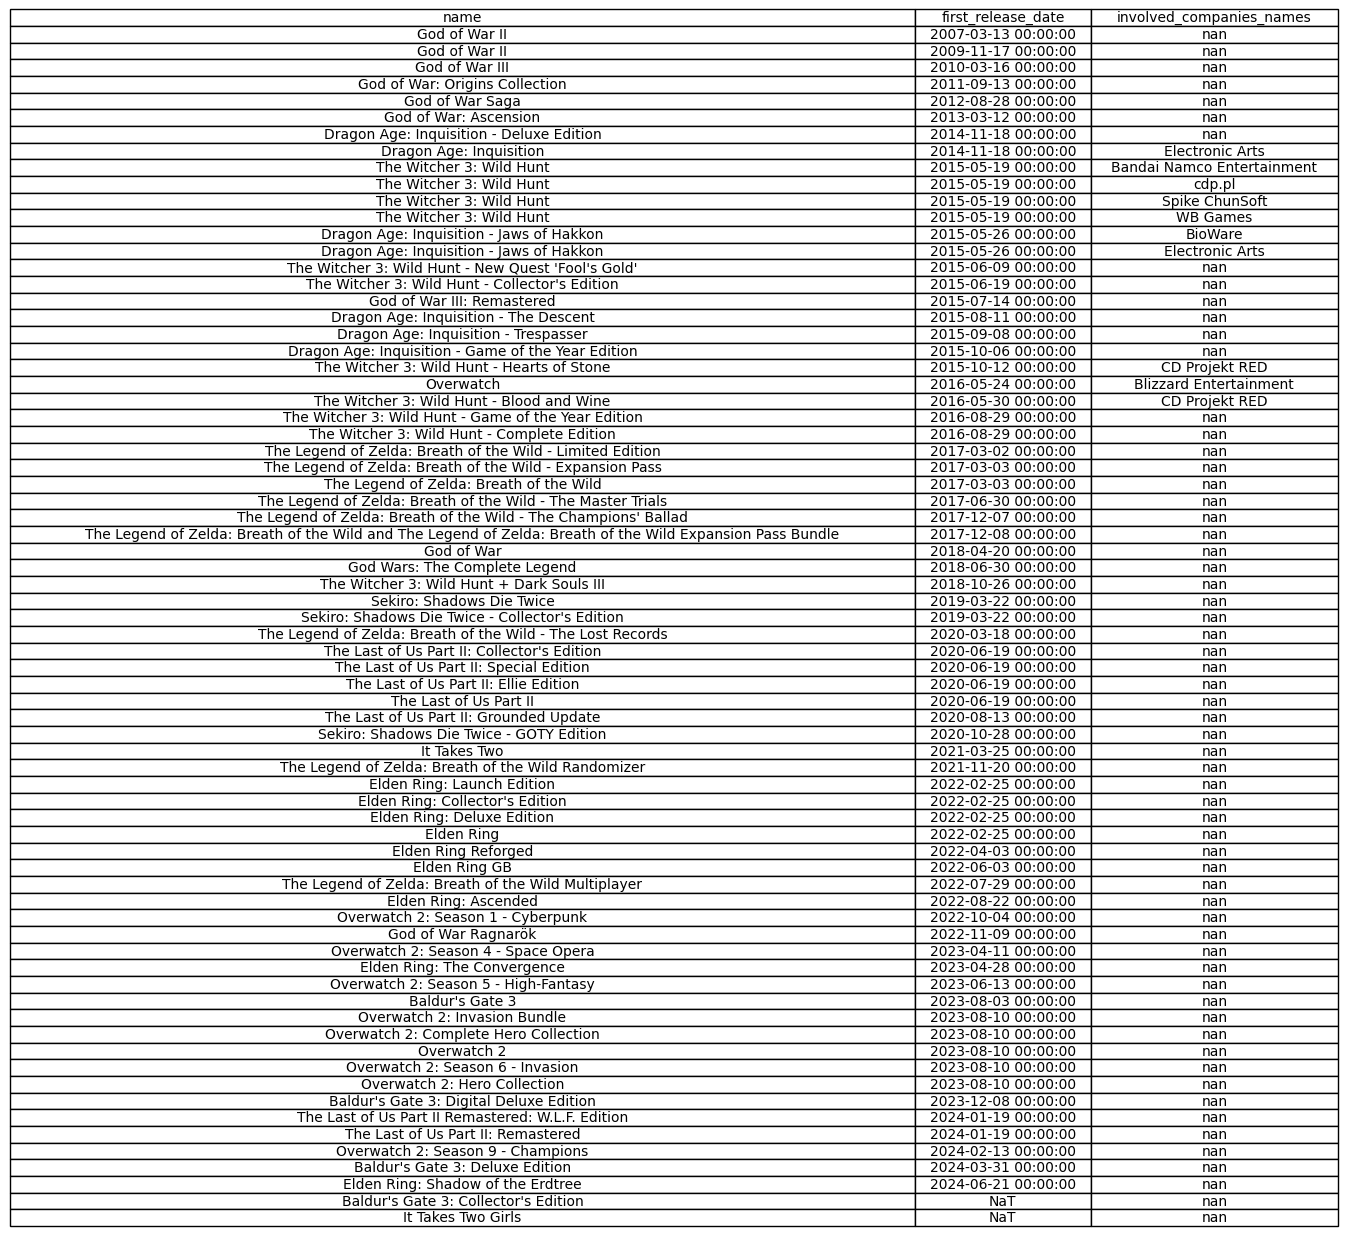

In [ ]:
url_games = 'https://api.igdb.com/v4/games'
url_involved_companies = 'https://api.igdb.com/v4/involved_companies'
url_companies = 'https://api.igdb.com/v4/companies'

#Jogos de interesse
games_of_interest = [
    "Baldur's Gate 3",
    "Elden Ring",
    "It Takes Two",
    "The Last of Us Part II",
    "Sekiro: Shadows Die Twice",
    "God of War",
    "The Legend of Zelda: Breath of the Wild",
    "Overwatch",
    "The Witcher 3: Wild Hunt",
    "Dragon Age: Inquisition"
]

def get_game_data(game_name):
    query = f'search "{game_name}"; fields id, name, first_release_date, involved_companies;'
    response = requests.post(url_games, headers=headers, data=query)

    if response.status_code == 200:
        print(f"Dados do jogo {game_name} obtidos com sucesso!")
        return response.json()
    else:
        print(f"Erro ao obter dados do jogo {game_name}: {response.status_code}, {response.reason}")
        return []

#Dados das empresas envolvidas
def get_involved_companies_data(company_ids):
    company_ids_str = ','.join(map(str, company_ids))
    fields = f'fields id, company; where id = ({company_ids_str});'
    response = requests.post(url_involved_companies, headers=headers, data=fields)

    if response.status_code == 200:
        print("Dados das empresas envolvidas obtidos com sucesso!")
        return response.json()
    else:
        print(f"Erro ao obter dados das empresas envolvidas: {response.status_code}, {response.reason}")
        return []

#Nomes das empresas
def get_companies_data(company_ids):
    company_ids_str = ','.join(map(str, company_ids))
    fields = f'fields id, name; where id = ({company_ids_str});'
    response = requests.post(url_companies, headers=headers, data=fields)

    if response.status_code == 200:
        print("Dados das empresas obtidos com sucesso!")
        return response.json()
    else:
        print(f"Erro ao obter dados das empresas: {response.status_code}, {response.reason}")
        return []

#Jogos definidos
all_games_data = []
for game in games_of_interest:
    game_data = get_game_data(game)
    if game_data:
        all_games_data.extend(game_data)

if all_games_data:
    #Extrair IDs das empresas envolvidas
    involved_company_ids = set()
    for game in all_games_data:
        if 'involved_companies' in game:
            involved_company_ids.update(game['involved_companies'])

    involved_companies_data = get_involved_companies_data(involved_company_ids)
    company_ids = [company['company'] for company in involved_companies_data]
    companies_data = get_companies_data(company_ids)

    company_id_to_name = {company['id']: company['name'] for company in companies_data}
    involved_company_id_to_company_id = {company['id']: company['company'] for company in involved_companies_data}

    #Nome das empresas aos dados dos jogos
    for game in all_games_data:
        if 'involved_companies' in game:
            game['involved_companies_names'] = [company_id_to_name[involved_company_id_to_company_id[company_id]] for company_id in game['involved_companies'] if company_id in involved_company_id_to_company_id]

    #DataFrame
    df_games = pd.DataFrame(all_games_data)

    #Filtrar e ordenar por data de lançamento
    df_games = df_games[['name', 'first_release_date', 'involved_companies_names']]
    df_games['first_release_date'] = pd.to_datetime(df_games['first_release_date'], unit='s')
    df_games = df_games.explode('involved_companies_names')
    df_games = df_games.sort_values(by='first_release_date')

    #Tabela
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    print(df_games)

    #Plotar tabela
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df_games.values, colLabels=df_games.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(df_games.columns))))
    plt.show()
else:
    print("Nenhum dado de jogo foi obtido.")

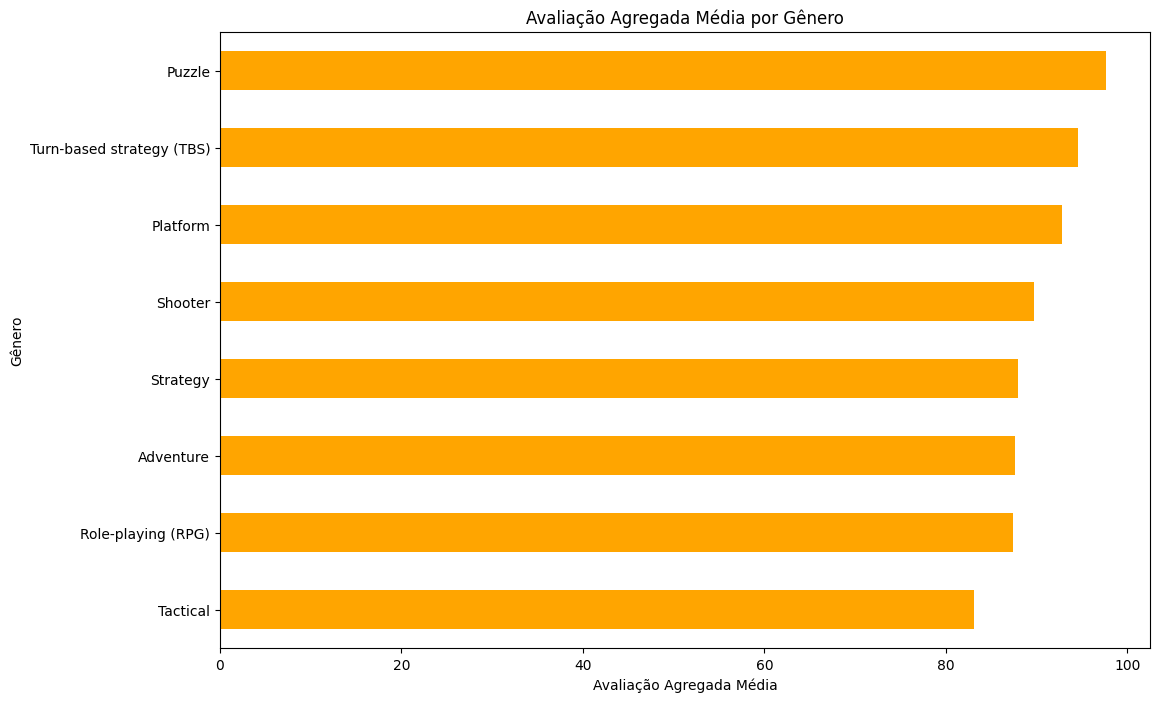

In [ ]:
# Calcular a média das avaliações por gênero
avg_rating_by_genre = df_genres.groupby('genre_names')['aggregated_rating'].mean().sort_values()

plt.figure(figsize=(12, 8))
avg_rating_by_genre.plot(kind='barh', color = 'orange')
plt.title('Avaliação Agregada Média por Gênero')
plt.xlabel('Avaliação Agregada Média')
plt.ylabel('Gênero')
plt.show()

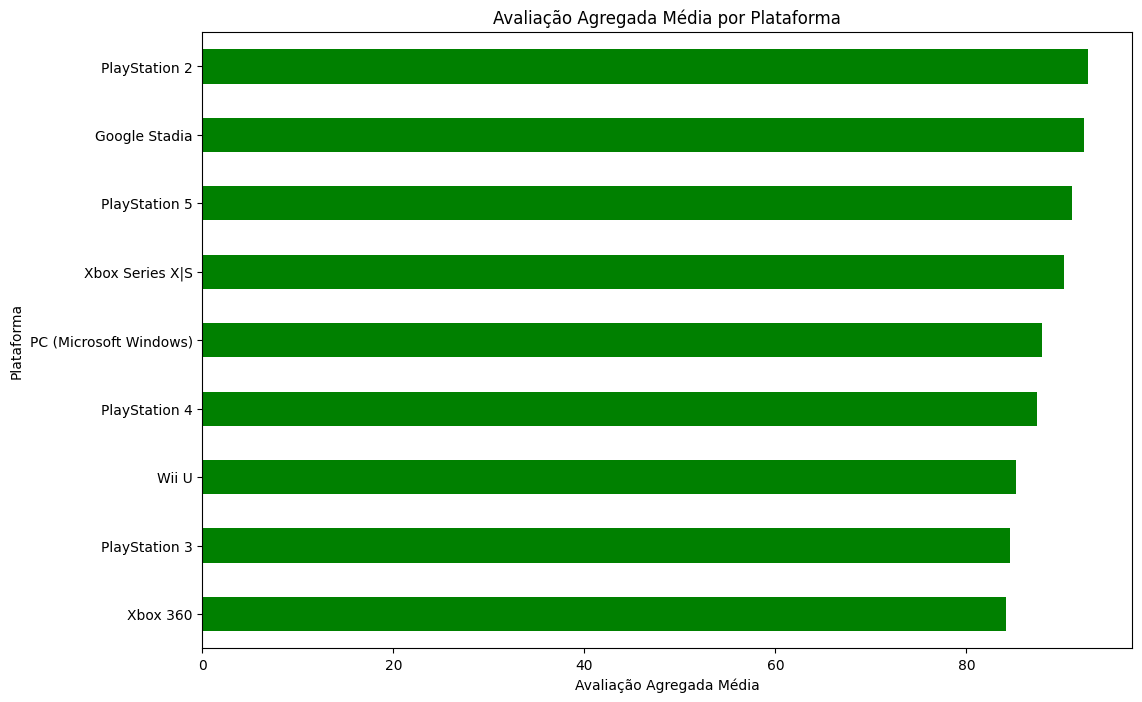

In [ ]:
# Calcular a média das avaliações por plataforma
avg_rating_by_platform = df_platforms.groupby('platform_names')['aggregated_rating'].mean().sort_values()

plt.figure(figsize=(12, 8))
avg_rating_by_platform.plot(kind='barh', color = 'green')
plt.title('Avaliação Agregada Média por Plataforma')
plt.xlabel('Avaliação Agregada Média')
plt.ylabel('Plataforma')
plt.show()

In [ ]:
fields = 'fields *;'

def get_companies_data():
    url = 'https://api.igdb.com/v4/companies'
    response = requests.post(url, headers=headers, data=fields)

    if response.status_code == 200:
        print("Dados das empresas obtidos com sucesso!")
        return response.json()
    else:
        print(f"Erro ao obter dados das empresas: {response.status_code}, {response.reason}")
        return []

companies_data = get_companies_data()

Dados das empresas obtidos com sucesso!


In [ ]:
if company_data:
    df_company = pd.json_normalize(company_data)
    nome_arquivo = 'dados_company.csv'

    df_company.to_csv(nome_arquivo, index=False)
    print(f"Dados das empresas salvos em {nome_arquivo}")

    df_company_carregado = pd.read_csv(nome_arquivo)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    print(df_company_carregado)

else:
    print("Nenhum dado de empresa foi coletado.")

Nenhum dado de empresa foi coletado.


In [ ]:
df_company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame
